# Inflation-deflation elongation

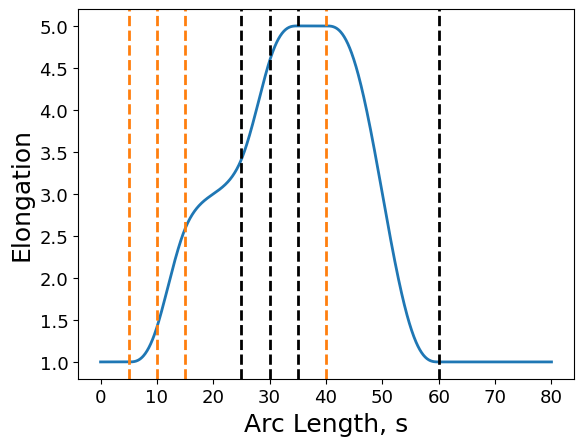

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# %matplotlib widget
# %matplotlib qt5
%matplotlib inline

def inflate_signal(x, switch, transition_len=1):
    switch = np.array(switch).reshape(1, -1)
    x = np.array(x).reshape(-1, 1)
    x_rel = x - switch  # (len(x), len(switch))
    y_inflate = np.zeros_like(x_rel)
    y_inflate[(x_rel >= (-transition_len)) & (x_rel <= 0)] = (
        (-x_rel[(x_rel >= (-transition_len)) & (x_rel <= 0)]) / transition_len)
    y_inflate[x_rel < (-transition_len)] = 1
    return y_inflate

def deflate_signal(x, switch, transition_len=1):
    switch = np.array(switch).reshape(1, -1)
    x = np.array(x).reshape(-1, 1)
    x_rel = x - switch  # (len(x), len(switch))
    y_deflate = np.zeros_like(x_rel)
    y_deflate[(x_rel >= (-transition_len)) & (x_rel <= 0)] = (
        1 + (x_rel[(x_rel >= (-transition_len)) & (x_rel <= 0)]) / transition_len)
    y_deflate[(x_rel > 0)] = 1
    return y_deflate

def compute_deformation_per_arc_len(arc_len, switches, transition_len=1, max_deform=1, min_deform=1):
    coeffs = np.array([0, 0, 0, 10, -15, 6])
    poly = np.polynomial.Polynomial(coeffs)
    d_poly = poly.deriv()
    
    switches = switches if isinstance(switches, (np.ndarray, list)) else [switches]
    arc_len = np.array(arc_len).flatten() if not isinstance(arc_len, np.ndarray) else arc_len
    def_init = np.zeros_like(arc_len)
    deformation = [def_init]
    d_deformation = [def_init]

    deformation = (
        poly(inflate_signal(arc_len, switches[::2], transition_len)).sum(axis=1)
        + (poly(deflate_signal(arc_len, switches[1::2], transition_len)) - 1).sum(axis=1))
    deformation = (max_deform - min_deform) * deformation + min_deform
    d_deformation = (
        - (max_deform - min_deform) / transition_len * d_poly(inflate_signal(arc_len, switches[::2], transition_len)).sum(axis=1)
        + (max_deform - min_deform) / transition_len * d_poly(deflate_signal(arc_len, switches[1::2], transition_len)).sum(axis=1))
   
    return deformation, d_deformation

num_frusta = 78  # number of frusta
min_length = 80  # mm
max_length = 415  # mm
len_static = (max_length + min_length) / (2*num_frusta)
# single frustum dynamic part length, h [mm]:
len_dynamic = (max_length - min_length) / (2*num_frusta)
# single frustum length, l_open - total [mm]:
len_open = len_static + len_dynamic
len_closed = len_static - len_dynamic

# transition_len = 100 * l_closed
# transition_len = 5 * l_closed
transition_len = 20
max_deform = max_length / min_length
max_deform = 5
min_deform = 1
max_len = num_frusta * len_closed
max_switch_len = max_len + transition_len
num_samples = 1000
arc_len = np.linspace(0, max_len, num_samples)

switches = [
    0.6,
    0.35,
    0.3,
    0.25
]  # normalized
# switches = [0.5]
# switches = 0
# switches = np.linspace(1, 0, 200)
# switches = [0.9, 0.3]

deformation, d_deformation = compute_deformation_per_arc_len(
    arc_len, np.array(switches)*max_switch_len, transition_len, max_deform, min_deform)
arc_len_samples = np.array([10, 30])
# arc_len_samples = np.linspace(0.15, 0.85, 2) * max_len
deform_samples, d_deform_samples = compute_deformation_per_arc_len(
    arc_len_samples, np.array(switches)*max_switch_len, transition_len, max_deform, min_deform)
d_deform_numeric = (deformation[1:] - deformation[:-1]) / (arc_len[1:] - arc_len[:-1])
d_deform_arc_len = (arc_len[1:] + arc_len[:-1]) / 2

tick_label_size = 13
axis_label_size = 18
title_size = 22
plot_line_width = 2
marker_size = 8

fig, ax = plt.subplots()
ax.plot(arc_len, np.array(deformation), linewidth=plot_line_width)
for switch in switches:
    ax.axvline(x=switch*max_switch_len, linestyle='--', color='black', linewidth=plot_line_width)
    ax.axvline(x=switch*max_switch_len-transition_len, linestyle='--', color='tab:orange', linewidth=plot_line_width)
    
ax.set_xlabel("Arc Length, s", size=axis_label_size)
ax.set_ylabel("Elongation", size=axis_label_size)
# ax.set_title("Frustum tri-linear model", size=title_size)
# ax.set_xticks([])
# ax.set_yticks([])
ax.tick_params(labelsize=tick_label_size)
# plt.plot(arc_len, np.array(d_deformation))
# plt.plot(d_deform_arc_len, np.array(d_deform_numeric), '-.')
# plt.plot(arc_len_samples, np.array(deform_samples), 'xr')
# plt.plot(np.array(switches).reshape(1, -1).repeat(2, axis=0) * max_switch_len,
#          np.vstack([np.zeros_like(switches),
#                     np.ones_like(switches) * max_deform]),
#          '--',
#          color='black')

# plt.show()

# Long-wave approximation

In [21]:
import numpy as np

num_frusta = 78
spinodal_stiffness = -3119  # Pa * m
len_open = 4.82 * 1e-3  # m
len_closed = 1.38 * 1e-3  # m
len_dynamic = (len_open - len_closed) / 2
len_static = len_open - len_dynamic
len_straw_closed = len_closed * num_frusta
len_straw_open = len_open * num_frusta
snap_open_len = len_closed
viscocity = 60  # Pa*s
snap_open_force = 6.24  #  N
external_force = 0  #  N
straw_internal_radius = 6.5 * 1e-3  # m
inlet_pressure = 200 * 1e3  # Pa
# inlet_pressure = 500 * 1e3  # Pa

is_open = 0  # 0 for closed-ended straw, 1 for open-ended straw
end_pressure = 0

straw_cross_area = np.pi * straw_internal_radius**2
force_delta = snap_open_force - external_force + straw_cross_area * (is_open * end_pressure - inlet_pressure)

# x = np.sqrt(
#     (len_open * spinodal_stiffness * t) / (4 * np.pi * viscocity)
#     * np.log(
#             (force_delta)
#             / (force_delta + spinodal_stiffness * (len_open - snap_open_len))
#         ) ** (-1)
#     )

x = len_straw_open
t = (x**2 * np.log((force_delta) / (force_delta + spinodal_stiffness * (len_open - snap_open_len)))
     * (4 * np.pi * viscocity) / (len_open * spinodal_stiffness))

elongation = x * (len_open - snap_open_len) / len_open

In [22]:
print(f'l_static = {(len_static * 1e3):.1f} [mm]')
print(f'l_dyn = {(len_dynamic * 1e3):.1f} [mm]')
print(f'straw_len_closed = {(len_straw_closed * 1e3):.1f} [mm]')
print(f'straw_len_open = {(len_straw_open * 1e3):.1f} [mm]')
print(f'x = {(x * 1e3):.1f} [mm]')
print(f'elongation = {(elongation * 1e3):.1f} [mm]')
print(f'num_frusta_open = {int(elongation / (2 * len_dynamic))}')
print(f'{t = }')

l_static = 3.1 [mm]
l_dyn = 1.7 [mm]
straw_len_closed = 107.6 [mm]
straw_len_open = 376.0 [mm]
x = 376.0 [mm]
elongation = 268.3 [mm]
num_frusta_open = 78
t = 3.0071543041072175


In [23]:
protruded_deformation = len_open / len_closed
protruded_deformation

3.492753623188406

In [24]:
import numpy as np

num_samples = 257
np.linspace(0, num_samples-1, 10).astype(int)

array([  0,  28,  56,  85, 113, 142, 170, 199, 227, 256])

# Inlet viscous resistance model

In [79]:
import numpy as np

num_frusta = 78
min_length = 80 * 1e-3  # m
max_length = 415 * 1e-3  # m

# According to Breitman's paper SI, our straw opens to approx 530 mm under pressure of 200 kPa:
pressurized_max_length = 530 * 1e-3  # mm
max_length = max_length * pressurized_max_length/max_length  # Elastic deformation

len_static = (max_length + min_length) / (2*num_frusta)
# single frustum dynamic part length, h [mm]:
len_dynamic = (max_length - min_length) / (2*num_frusta)
# single frustum length, l_open - total [mm]:
len_open = len_static + len_dynamic
len_closed = len_static - len_dynamic
# len_open = 4.82 * 1e-3  # m
# len_closed = 1.38 * 1e-3  # m
# len_dynamic = (len_open - len_closed) / 2
# len_static = len_open - len_dynamic
len_straw_closed = len_closed * num_frusta
len_straw_open = len_open * num_frusta
snap_open_len = len_closed
viscocity = 60  # Pa*s
snap_open_force = 6.24  #  N
external_force = 0  #  N
straw_internal_radius = 6.5 * 1e-3  # m
# straw_internal_radius = 7.2 * 1e-3  # m

# inlet_pressure = 400 * 1e3  # Pa  # 24 sec
# inlet_pressure = 500 * 1e3  # Pa  # 16 sec
# inlet_pressure = 600 * 1e3  # Pa  # 11 sec
inlet_pressure = np.array([400, 500, 600]) * 1e3  # Pa

straw_cross_area = np.pi * straw_internal_radius**2
critical_pressure = 28 * 1e3  # Pa - Ezra measure 18.12.2022
# critical_pressure = 40 * 1e3  # Pa - Test
critical_pressure_retract = -13 * 1e3 # Pa - Ezra measure 18.12.2022
critical_deformation = 0.372 * 1e-3 # m - Ezra measure 18.12.2022
# critical_pressure = 262 * 1e3  # Pa
# critical_pressure = 250 * 1e3  # Pa
# critical_pressure = snap_open_force / straw_cross_area
spinodal_stiffness = (critical_pressure - critical_pressure_retract) / (2 * len_dynamic - 2 * critical_deformation)  # Pa / m
# spinodal_stiffness = -3119 / straw_cross_area  # Pa / m
# spinodal_stiffness = -4000 / straw_cross_area  # Pa / m

# inlet_radius = 6 * 1e-3  # m
inlet_radius = 5 * 1e-3  # m - Ezra measure 18.12.2022
# inlet_radius = 4.7 * 1e-3  # m -Test
inlet_len = 30 * 1e-3  # m - Ezra measure 18.12.2022
num_straws = 12

In [80]:
len_static * 1000

3.9102564102564106

In [81]:
len_dynamic * 1000

2.8846153846153846

In [82]:
len_open * 1e3

6.794871794871796

In [83]:
critical_deformation / len_closed * 100

36.269999999999996

In [84]:
(len_open - len_closed) / len_closed * 100

562.5

In [85]:
critical_deformation / (len_open - len_closed) * 100

6.4479999999999995

In [86]:
spinodal_stiffness * straw_cross_area  # N / m

1082.9400925231441

In [87]:
frustum_elongation_norm = 2 * len_dynamic / len_open

pressure_delta_norm = ((inlet_pressure - critical_pressure)
                       / (len_open * spinodal_stiffness))

inlet_resistance_norm = (num_straws
                         * (straw_internal_radius / inlet_radius)**4
                         * inlet_len / len_open)

frustum_open_char_time_norm = np.log(frustum_elongation_norm / pressure_delta_norm + 1)

final_frustum_open_time_norm = (frustum_open_char_time_norm
                                * (num_frusta * (num_frusta + 1) / 2
                                   + num_frusta * inlet_resistance_norm))

characteristic_flow_time = ((8 * viscocity * len_open)
                            / (spinodal_stiffness * straw_internal_radius**2))

final_frustum_open_time = final_frustum_open_time_norm * characteristic_flow_time

viscous_resistance_norm = 0.5 + inlet_resistance_norm

t = np.linspace(0, final_frustum_open_time, 1000)

norm_time = t / characteristic_flow_time

num_open_frusta = (np.sqrt(2 * norm_time / frustum_open_char_time_norm
                           + viscous_resistance_norm**2) - viscous_resistance_norm)

len_open_region = num_open_frusta * len_closed

elongation = num_open_frusta * 2 * len_dynamic

print(f'{final_frustum_open_time = }')

final_frustum_open_time = array([16.77873321, 13.38700158, 11.1365263 ])


In [88]:
actual_opening_time = np.array([24, 16, 11])
print(f'Errors: {np.abs(final_frustum_open_time - actual_opening_time) / actual_opening_time * 100}%')

Errors: [30.08861161 16.33124012  1.24114815]%


In [89]:
final_frustum_open_time_norm_no_resistance = (frustum_open_char_time_norm
                                         * (num_frusta * (num_frusta + 1) / 2))
final_frustum_open_time_no_resistance = (final_frustum_open_time_norm_no_resistance
                                         * characteristic_flow_time)
t_no_resistance = np.linspace(0, final_frustum_open_time_no_resistance, 1000)
norm_time_no_resistance = t_no_resistance / characteristic_flow_time
num_open_frusta_no_resistance = (np.sqrt(2 * norm_time_no_resistance / frustum_open_char_time_norm
                                         + 0.5**2) - 0.5)

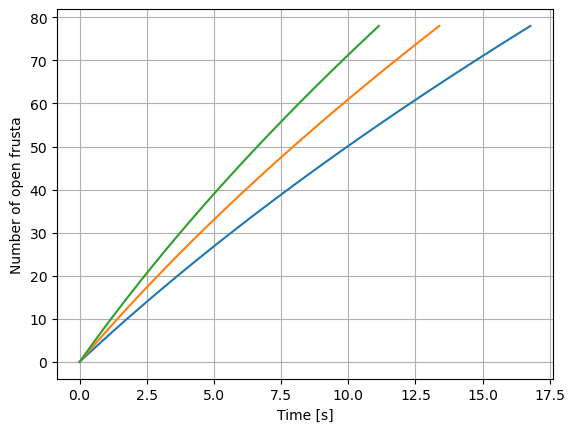

In [90]:
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

plt.plot(t, num_open_frusta)
# plt.plot(t_no_resistance, num_open_frusta_no_resistance)
plt.xlabel('Time [s]')
plt.ylabel('Number of open frusta')
plt.grid()

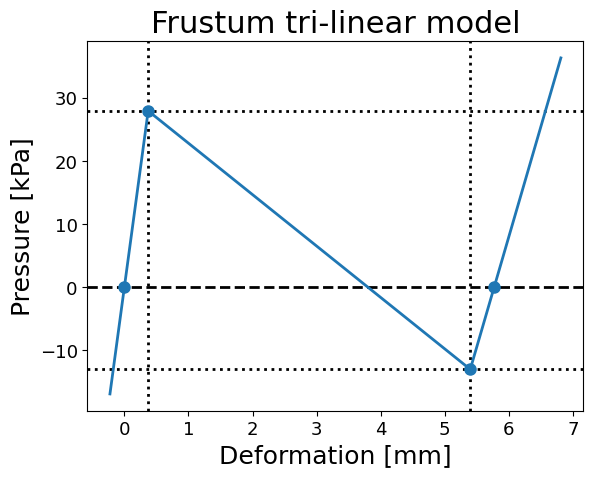

In [91]:
# %matplotlib widget
%matplotlib inline

slope_elastic_retracted = critical_pressure / critical_deformation
slope_transition = (critical_pressure - critical_pressure_retract) / (2 * len_dynamic - 2 * critical_deformation)
slope_elastic_protruded = -critical_pressure_retract / critical_deformation

start_pressure = 1.3 * critical_pressure_retract
start_deformation = start_pressure / slope_elastic_retracted
final_pressure = 1.3 * critical_pressure
final_deformation = 2 * len_dynamic + final_pressure / slope_elastic_protruded

tri_linear_model_deformation = np.array([
    start_deformation,
    0,
    critical_deformation,
    2 * len_dynamic - critical_deformation,
    2 * len_dynamic,
    final_deformation,
])

tri_linear_model_pressure = np.array([
    start_pressure,
    0,
    critical_pressure,
    critical_pressure_retract,
    0,
    final_pressure,
])

tick_label_size = 13
axis_label_size = 18
title_size = 22
plot_line_width = 2
marker_size = 8

fig, ax = plt.subplots()
ax.axvline(
    critical_deformation * 1e3,
    linestyle=':',
    color='black',
    linewidth=plot_line_width,
)
ax.axvline(
    (2 * len_dynamic - critical_deformation) * 1e3,
    linestyle=':',
    color='black',
    linewidth=plot_line_width,
)
ax.axhline
ax.axhline(
    0,
    linestyle='--',
    color='black',
    linewidth=plot_line_width,
)
ax.axhline(
    critical_pressure / 1e3,
    linestyle=':',
    color='black',
    linewidth=plot_line_width,
)
ax.axhline(
    critical_pressure_retract / 1e3,
    linestyle=':',
    color='black',
    linewidth=plot_line_width,
)
ax.plot(
    tri_linear_model_deformation * 1e3,
    tri_linear_model_pressure / 1e3, linestyle='-',
    linewidth=plot_line_width,
)
ax.plot(
    tri_linear_model_deformation[1:-1] * 1e3,
    tri_linear_model_pressure[1:-1] / 1e3,
    linestyle='',
    marker='o',
    color='tab:blue',
    linewidth=plot_line_width,
    markersize=marker_size,
)

ax.set_xlabel("Deformation [mm]", size=axis_label_size)
ax.set_ylabel("Pressure [kPa]", size=axis_label_size)
ax.set_title("Frustum tri-linear model", size=title_size)
ax.tick_params(labelsize=tick_label_size)

# plt.show()

In [92]:
(2*len_dynamic-critical_deformation)*1e3

5.397230769230769

In [93]:
critical_deformation / len_dynamic

0.12896